In [11]:
# Load ML Pkgs
import pandas as pd
import numpy as np
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [12]:
import pandas as pd
df=pd.read_csv('cleaned_text.csv')

In [13]:
df.head()

,Unnamed: 0,cleaned_text,emotion
0,0,fuckin m transtelecom,anger
1,1,working but it s fridaaaayyyyy,anger
2,2,packing i don t like it,anger
3,3,i tried to dye my hair and all i got was a blo...,anger
4,4,quot locked up abroad quot makes bein half bro...,anger


In [14]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,cleaned_text,emotion
0,fuckin m transtelecom,anger
1,working but it s fridaaaayyyyy,anger
2,packing i don t like it,anger
3,i tried to dye my hair and all i got was a blo...,anger
4,quot locked up abroad quot makes bein half bro...,anger


In [15]:
import numpy as np

In [16]:
df["emotion"].value_counts()


criticism    25042
hate         14866
anger        14830
offensive    10579
joy          10200
optimism      8996
fear          8828
sadness       8520
love          6296
surprise      5106
Name: emotion, dtype: int64

In [17]:
df.head()

,cleaned_text,emotion
0,fuckin m transtelecom,anger
1,working but it s fridaaaayyyyy,anger
2,packing i don t like it,anger
3,i tried to dye my hair and all i got was a blo...,anger
4,quot locked up abroad quot makes bein half bro...,anger


In [18]:
df.shape

(113263, 2)

In [19]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)

In [20]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.1, random_state=2, stratify=df["emotion"])
#train, test = train_test_split(df, test_size=0.1, random_state=2, stratify=df["sentiment"])

In [21]:
label_encoder = get_label_encoder_obj(train["emotion"])
train["emotion"] = get_y_label_encoder(label_encoder, train["emotion"])
val["emotion"] = get_y_label_encoder(label_encoder, val["emotion"])

In [22]:
num_classes = len(np.unique(train["emotion"]))
num_classes

10

In [23]:
X_train = train["cleaned_text"].values
y_train = train["emotion"].values
X_val = val["cleaned_text"].values
y_val = val["emotion"].values

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def CountVectorizer_fit(X_train, ngram_range=(1,1)):
    count_vect = CountVectorizer(ngram_range=ngram_range)
    return count_vect.fit(X_train)


def CountVectorizer_transform(count_vect, X):
    return count_vect.transform(X)

In [25]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle


def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
                                  
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(20,20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(label_encoder.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("multiclass characteristic")
    plt.legend(loc="lower right")
    plt.show()
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.classes_],
                  columns = [i for i in label_encoder.classes_])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.classes_))

In [26]:
count_vect = CountVectorizer_fit(X_train, ngram_range=(1,3))
X_train_counts = CountVectorizer_transform(count_vect, X_train)
X_val_counts = CountVectorizer_transform(count_vect, X_val)
from sklearn.feature_extraction.text import TfidfTransformer


def TfidfTransformer_fit(X_train_counts, use_idf=True):
    tf_transformer = TfidfTransformer(use_idf=use_idf)
    return tf_transformer.fit(X_train_counts)


def TfidfTransformer_transform(tf_transformer, X_counts):
    return tf_transformer.transform(X_counts)

In [27]:
tf_transformer = TfidfTransformer_fit(X_train_counts)
X_train_tfidf = TfidfTransformer_transform(tf_transformer, X_train_counts)
X_val_tfidf = TfidfTransformer_transform(tf_transformer, X_val_counts)

In [28]:
SEQ_LEN = max([len(x.split()) for x in train["cleaned_text"].values])
SEQ_LEN

78

In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('punkt')
nltk.download('wordnet')

oov_tok = "<oov_tok>"

def count_vectorizer(corpus):
    vectorizer = CountVectorizer(analyzer='word')
    corpus_words = vectorizer.fit_transform(corpus)
    return len(vectorizer.vocabulary_)


def get_tokenizer_obj(text_list, num_words):
    tokenizer = Tokenizer(lower=True, split=" ", num_words=num_words, oov_token=oov_tok)
    tokenizer.fit_on_texts(text_list)
    return tokenizer, len(tokenizer.word_index)


def tokenize_texts_to_sequences(tokenizer, text_list):
     return tokenizer.texts_to_sequences(text_list)

    
def padding_sequences(x_arr, max_len):
    x_arr = pad_sequences(x_arr, maxlen=max_len, value=0, padding='post')
    return x_arr 


def get_num_words(df, col):
    return count_vectorizer(df[col])


def get_max_statment_len(df, col):
    return max([len(text.split()) for text in df[col]])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [30]:
col = "cleaned_text"
num_words = get_num_words(train, col)
max_statment_len = get_max_statment_len(train, col)
tokenizer, vocab_size = get_tokenizer_obj(train[col].values, num_words)
X_train = tokenize_texts_to_sequences(tokenizer, train[col].values)
X_train = padding_sequences(X_train, max_statment_len)
X_val = tokenize_texts_to_sequences(tokenizer, val[col].values)
X_val = padding_sequences(X_val, max_statment_len)
from sklearn.utils import class_weight

def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                      classes=np.unique(y),
                                                      y=y)
    return {k: v for k, v in enumerate(class_weights)}
# class_weights = get_class_weights(train["sentiment"].valu

In [31]:
train[['cleaned_text', 'emotion']]

,cleaned_text,emotion
17203,next time on the curse of oak island,2
54893,dems can end this they chose not to,1
65035,yeah i usually am using just the regular blue ...,1
109817,so are the olympics over in brazil yet or what...,6
91890,i really wanna go to in feb mar in san diego n...,8
...,...,...
52689,errr i didn t want to risk get in trouble with...,1
97901,you gotta follow quot boobfeed quot its incred...,9
309,it s really frustrating when your professors d...,0
46343,we will see i hope your right all we can do is...,7


In [32]:
y_train = one_hot_encode(train["emotion"], num_classes)
y_val = one_hot_encode(val["emotion"], num_classes)
y_train.shape

(101936, 10)

In [33]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.3 MB/s 


In [34]:
import tensorflow as tf
import keras.backend as K


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [35]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Input, Dropout, Conv1D, Reshape, Permute, Lambda
from keras.layers import RepeatVector, Flatten, multiply, Dropout
from keras.models import Model
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from os.path import join
import time


def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return modell

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, TIME_STEPS):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) 
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

def build_model(MAX_NB_WORDS,
                MAX_TEXT_LEN,
                nb_classes,
                learning_rate=2e-5,
                epsilon=1e-08):
    EMBEDDING_DIM = 100
    inputs = Input(name='inputs',shape=[MAX_TEXT_LEN])
    layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_TEXT_LEN)(inputs)
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out, MAX_TEXT_LEN)
    attention_mul = Flatten()(attention_mul)
    output = Dense(nb_classes, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate,epsilon=epsilon),
                  loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])
    print(model.summary())
    return model


def train_model(model, X_train, y_train, X_val, y_val,
                #class_weights,
                weights_dir,
                epochs=20,
                mini_batch_size=32,
                ):
    model_weights_file_path = join(weights_dir, "custom_model_weights.h5")
    checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=5)
    plotlosses = PlotLossesKeras()
    call_backs = [checkpoint, early_stopping, plotlosses]
    start_time = time.time()

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=mini_batch_size,
                        callbacks=call_backs,
                        #class_weight=class_weights,
                        verbose=1)

    duration = time.time() - start_time
    print("Model take {} S to train ".format(duration))
    return model, history


def predict(model, X_test):
    return model.predict(X_test)

In [36]:
max_text_length = X_train.shape[1]
model = build_model(vocab_size,                    
                    max_text_length,
                    num_classes,
                    learning_rate=0.001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 78)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 78, 100)      4892800     ['inputs[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 78, 64)       42240       ['embedding[0][0]']              
                                                                                                  
 permute (Permute)              (None, 64, 78)       0           ['lstm[0][0]']                   
                                                                                              

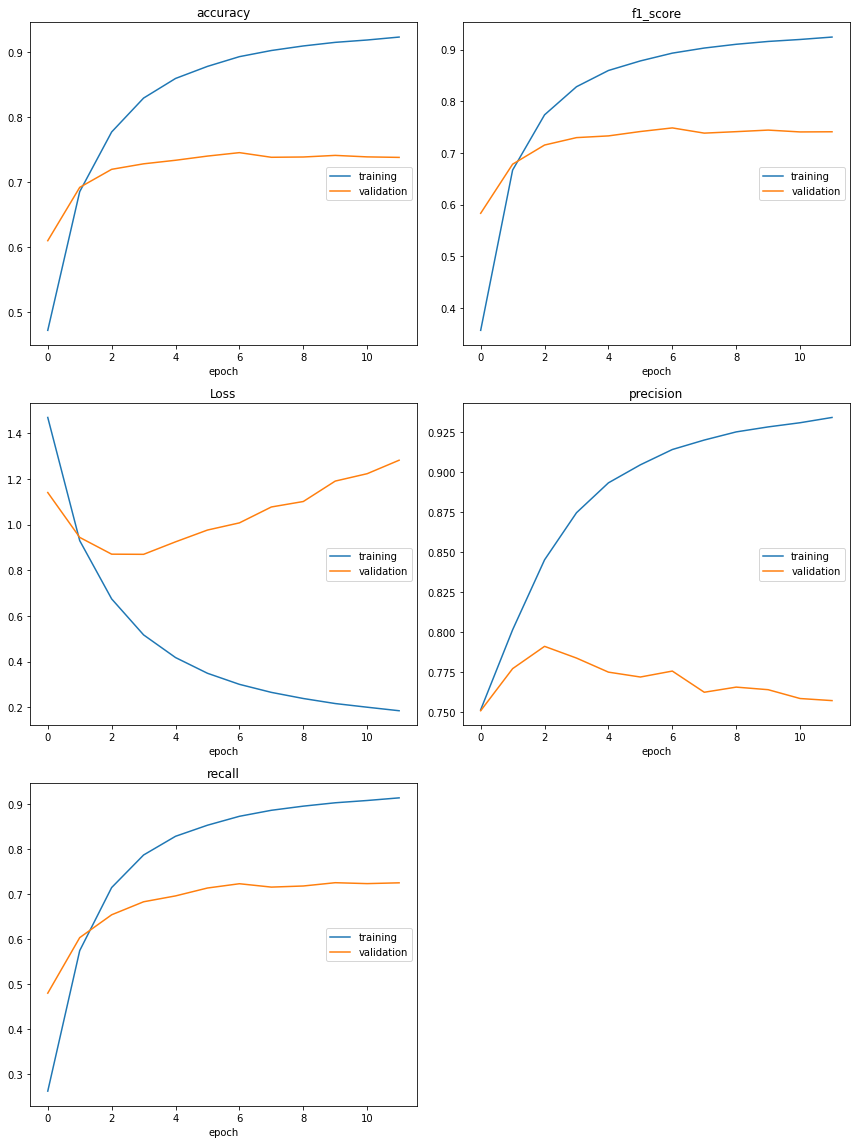

accuracy
	training         	 (min:    0.472, max:    0.923, cur:    0.923)
	validation       	 (min:    0.610, max:    0.745, cur:    0.738)
f1_score
	training         	 (min:    0.356, max:    0.924, cur:    0.924)
	validation       	 (min:    0.583, max:    0.748, cur:    0.741)
Loss
	training         	 (min:    0.184, max:    1.469, cur:    0.184)
	validation       	 (min:    0.869, max:    1.282, cur:    1.282)
precision
	training         	 (min:    0.752, max:    0.934, cur:    0.934)
	validation       	 (min:    0.751, max:    0.791, cur:    0.757)
recall
	training         	 (min:    0.262, max:    0.915, cur:    0.915)
	validation       	 (min:    0.480, max:    0.726, cur:    0.726)
3186/3186 [==============================] - 36s 11ms/step - loss: 0.1844 - accuracy: 0.9235 - precision: 0.9344 - recall: 0.9147 - f1_score: 0.9243 - val_loss: 1.2817 - val_accuracy: 0.7381 - val_precision: 0.7573 - val_recall: 0.7256 - val_f1_score: 0.7409
Epoch 12: early stopping
Model take 456.0

(<keras.engine.functional.Functional at 0x7f019eb00510>,
 <keras.callbacks.History at 0x7f019e4e1ed0>)

In [37]:
weights_path = ""
train_model(model, X_train, y_train, 
            X_val, y_val,
            #class_weights,
            weights_path)

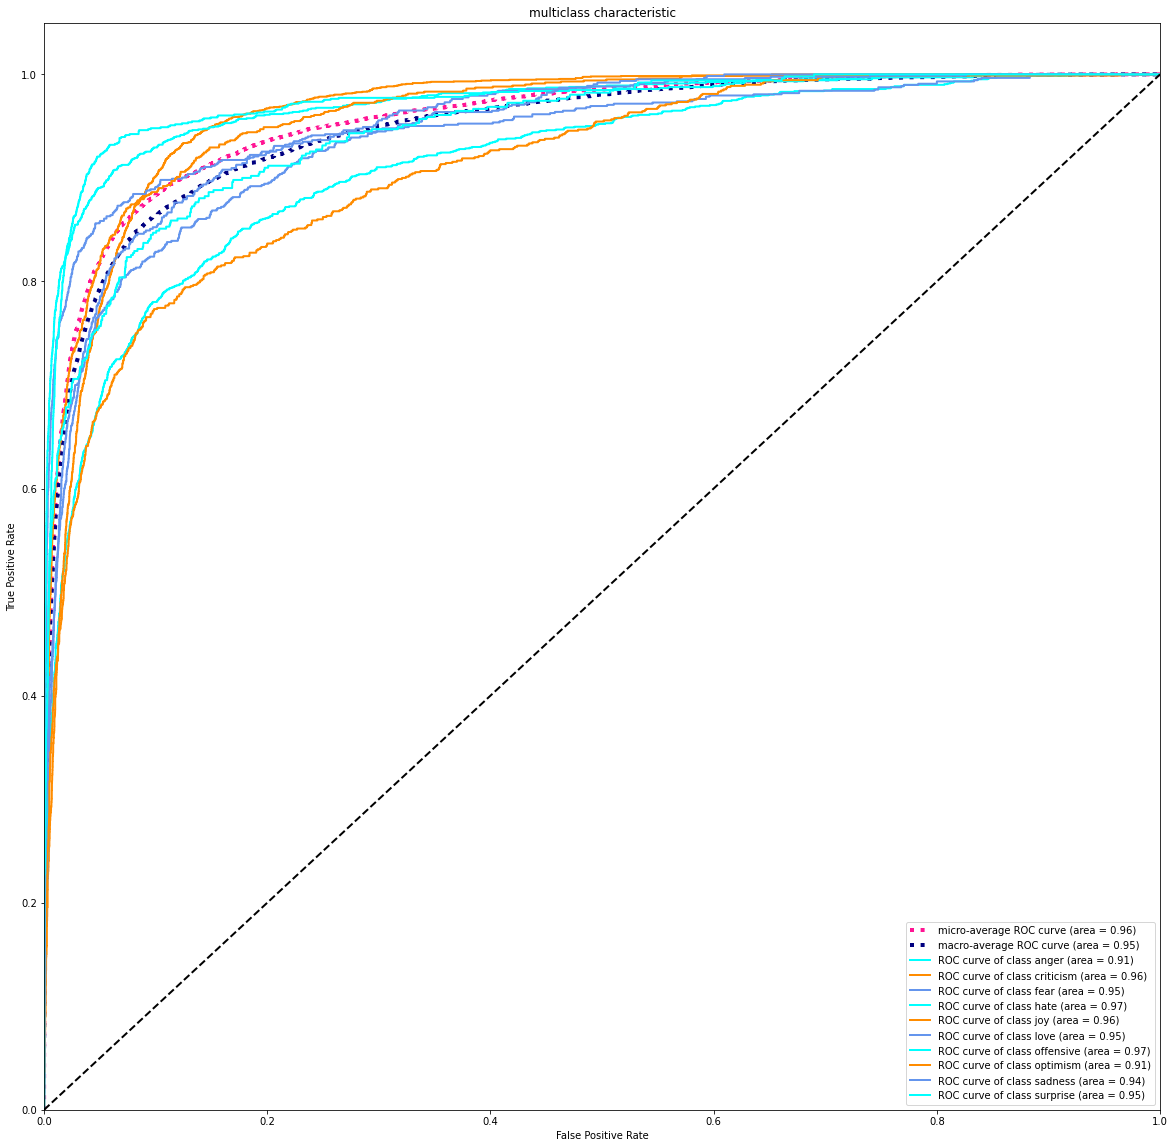

In [38]:
model.load_weights("./custom_model_weights.h5")
y_hat = model.predict(X_val)
ROC_plot(y_val, y_hat, label_encoder, num_classes)

Accuracy:  0.7454754127306435
Precision::  0.7454754127306435
Recall::  0.7454754127306435
F1_Score::  0.7454754127306435

Macro precision_recall_fscore_support (macro) average
(0.7302439769308311, 0.7192825199174107, 0.7234770731305274, None)

Macro precision_recall_fscore_support (micro) average
(0.7454754127306435, 0.7454754127306435, 0.7454754127306435, None)

Macro precision_recall_fscore_support (weighted) average
(0.7458524015837856, 0.7454754127306435, 0.7438276124360118, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

       anger       0.72      0.63      0.67      1483
   criticism       0.75      0.86      0.80      2504
        fear       0.81      0.76      0.78       883
        hate       0.88      0.81      0.84      1487
         joy       0.73      0.73      0.73      1020
        love       0.66      0.64      0.65       630
   offensive       0.79      0.84      0.82      1058
    optimism       0.65      0.57  

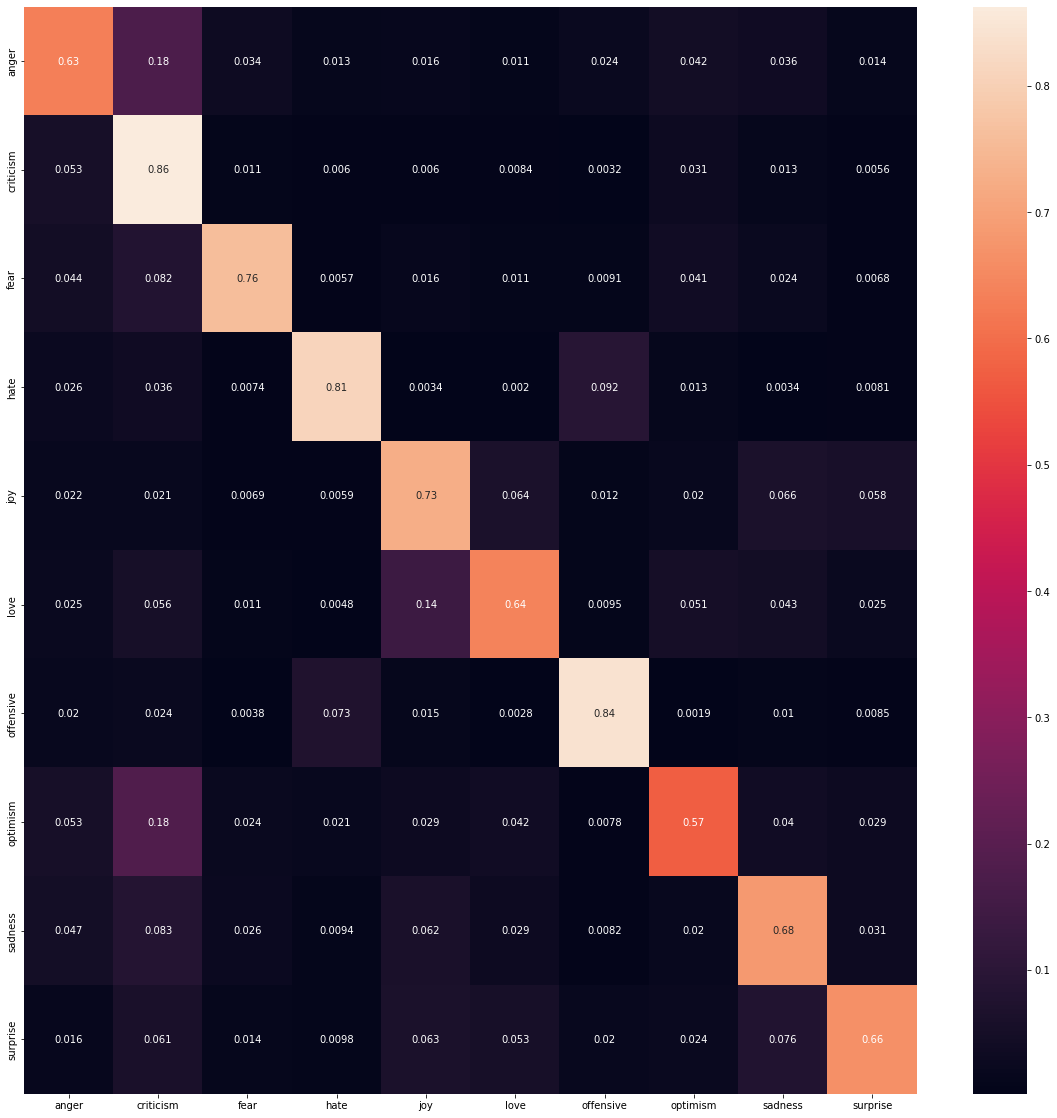

In [39]:
y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_val, axis=1)
print_score(y_pred, y_real, label_encoder)

In [40]:
# modelling

#**BERT**

In [41]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 163 kB 72.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 


In [42]:
sentences = df["cleaned_text"]
labels = df["emotion"]

In [43]:
label_encoder = get_label_encoder_obj(labels)
labels = get_y_label_encoder(label_encoder, labels)

In [44]:
#import

In [45]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/tokenizer_config.json


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.js

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/tf_model.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
#tokenizing

In [47]:
sent= sentences[0]

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)

tokenized_sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': [101, 6616, 2378, 1049, 9099, 9834, 8586, 5358, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [48]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] fuckin m transtelecom [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [49]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [50]:
#saving the files

In [51]:
import pickle

pickle_inp_path='bert_inp.pkl'
pickle_mask_path='bert_mask.pkl'
pickle_label_path='bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Pickle files saved as  bert_inp.pkl bert_mask.pkl bert_label.pkl


In [52]:
#loading files

In [53]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (113263, 64) Attention mask shape (113263, 64) Input label shape (113263,)


In [54]:
#train and test spilt

In [55]:
from sklearn.model_selection import train_test_split

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (90610, 64) Val input shape (22653, 64)
Train label shape (90610,) Val label shape (22653,)
Train attention mask shape (90610, 64) Val attention mask shape (22653, 64)


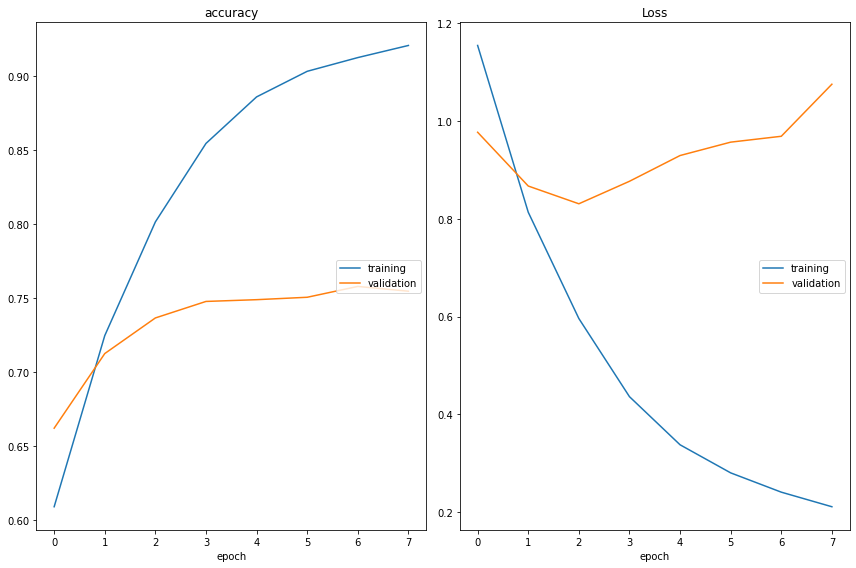

accuracy
	training         	 (min:    0.609, max:    0.921, cur:    0.921)
	validation       	 (min:    0.662, max:    0.758, cur:    0.755)
Loss
	training         	 (min:    0.211, max:    1.154, cur:    0.211)
	validation       	 (min:    0.831, max:    1.075, cur:    1.075)
2834/2834 [==============================] - 1272s 449ms/step - loss: 0.2112 - accuracy: 0.9210 - val_loss: 1.0750 - val_accuracy: 0.7547
Epoch 8: early stopping
Model take 10165.923173189163 S to train 


In [ ]:
start_time = time.time()

history=bert_model.fit([train_inp,train_mask],train_label,
                       batch_size=32,epochs=20,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks=callbacks)

duration = time.time() - start_time
print("Model take {} S to train ".format(duration))

In [ ]:
#classification and confusion matric

In [ ]:
y_hat = one_hot_encode(y_hat, num_classes)
y_true = one_hot_encode(val_label, num_classes)

In [ ]:
y_hat.shape, y_true.shape

In [ ]:
ROC_plot(y_true, y_hat, label_encoder, num_classes)

In [ ]:
#roc curve

In [ ]:
ROC_plot(y_true, y_hat, label_encoder, num_classes)

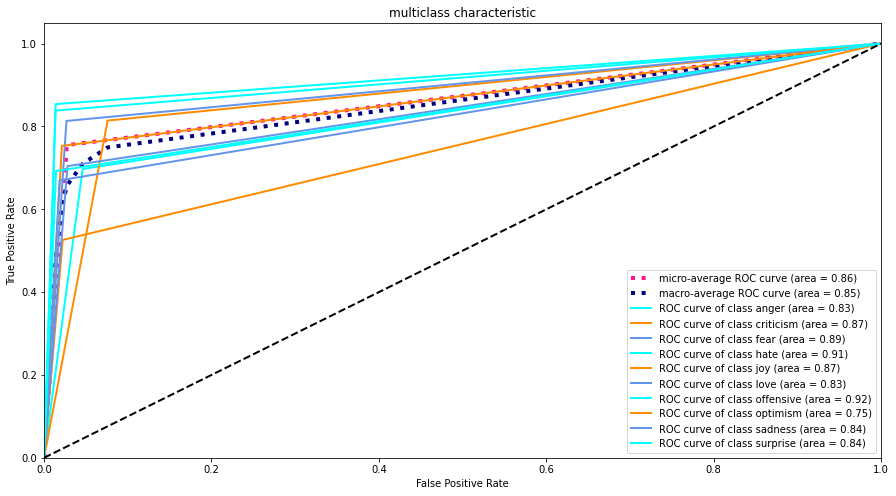

In [ ]:
ROC_plot(y_true, y_hat, label_encoder, num_classes)

Accuracy:  0.7549633812759199
Precision::  0.7549633812759199
Recall::  0.7549633812759199
F1_Score::  0.7549633812759199

Macro precision_recall_fscore_support (macro) average
(0.7428389809320798, 0.7362512820553393, 0.7379898801461267, None)

Macro precision_recall_fscore_support (micro) average
(0.7549633812759199, 0.7549633812759199, 0.7549633812759199, None)

Macro precision_recall_fscore_support (weighted) average
(0.7557086334153802, 0.7549633812759199, 0.753884019153268, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

       anger       0.70      0.70      0.70      2969
   criticism       0.76      0.81      0.78      5086
        fear       0.72      0.81      0.76      1730
        hate       0.90      0.84      0.87      2919
         joy       0.78      0.75      0.77      2061
        love       0.68      0.67      0.68      1281
   offensive       0.86      0.85      0.86      2103
    optimism       0.68      0.53   

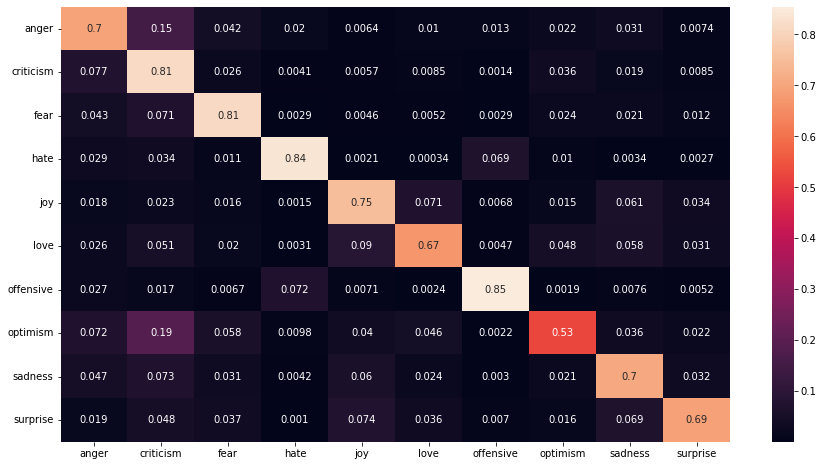

In [ ]:
y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_true, axis=1)
print_score(y_pred, y_real, label_encoder)

In [ ]:
#final output test accuarcies of all models

In [118]:
import pandas as pd
 
# initialise data of lists.
data = {'algo':['SVM', 'LR', 'DT','SGD', 'MNB','RNN', 'BI-LSTM', 'A-Lstm','BERT'], 'train acc':[77, 83, 96, 79,64,91,87,94,97],'test acc':[65, 68, 58, 66,59,66,72,76,78]}
 
# Create DataFrame
df = pd.DataFrame(data)
 

df
  

,algo,train acc,test acc
0,SVM,77,65
1,LR,83,68
2,DT,96,58
3,SGD,79,66
4,MNB,64,59
5,RNN,91,66
6,BI-LSTM,87,72
7,A-Lstm,94,76
8,BERT,97,78


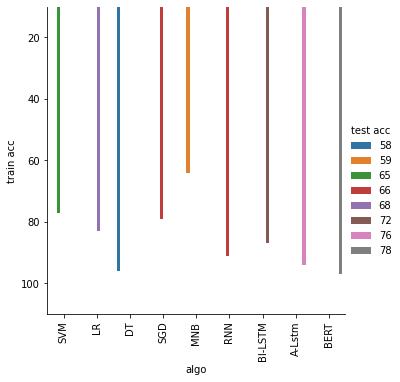

In [112]:
sns.catplot(x = 'algo', y='train acc', 
               hue = 'test acc',data=df, kind='bar',height=5)
plt.ylim(110,10)
plt.xticks(rotation='vertical')
plt.show()


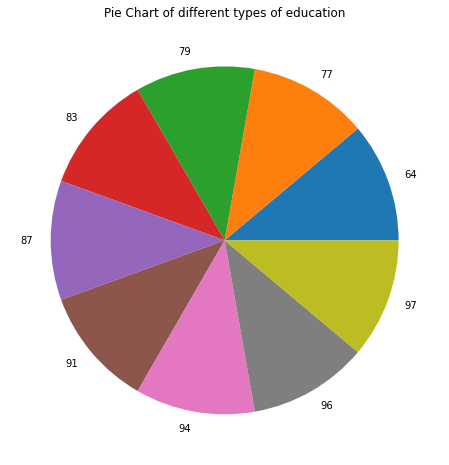

In [113]:
# Prepare Data
df = df.groupby('train acc').size()

# Make the plot with pandas
df.plot(kind='pie', subplots=True, figsize=(15, 8))
plt.title("Pie Chart of different types of education")
plt.ylabel("")
plt.show()

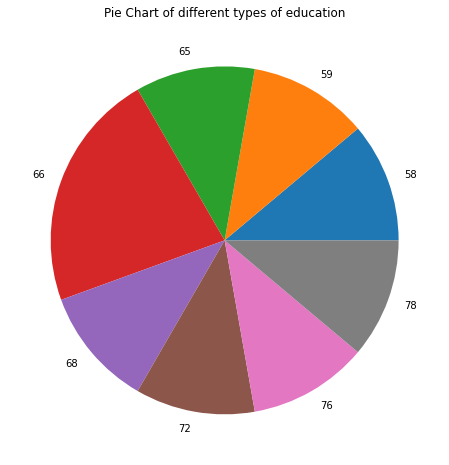

In [116]:
# Prepare Data
df = df.groupby('test acc').size()

# Make the plot with pandas
df.plot(kind='pie', subplots=True, figsize=(15, 8))
plt.title("Pie Chart of different types of education")
plt.ylabel("")
plt.show()

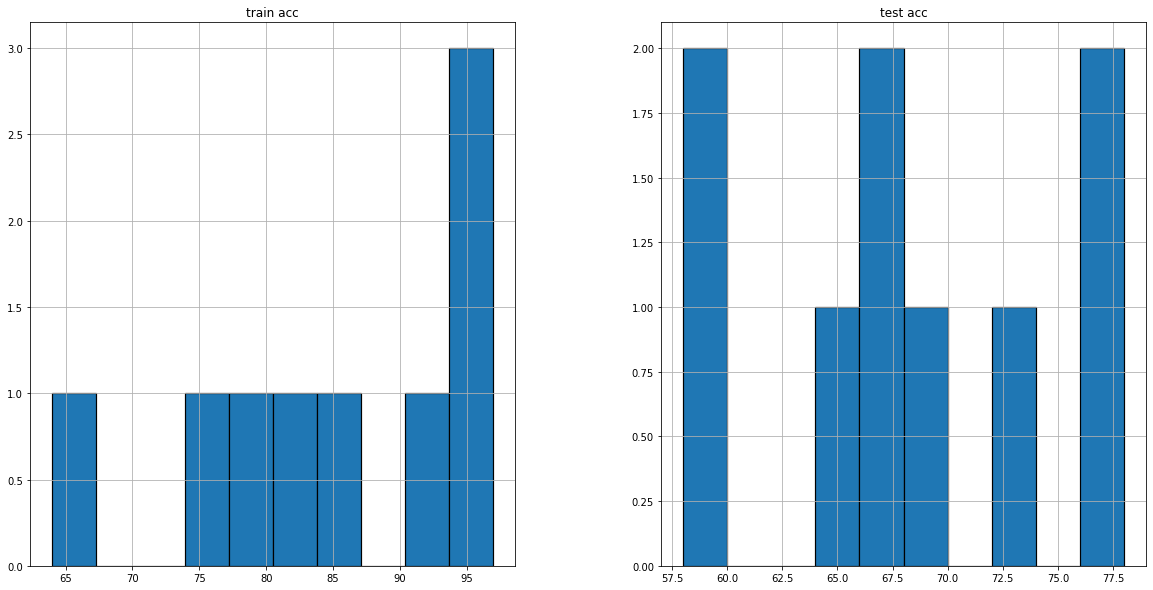

In [119]:
# Visulazing the distibution of the data for every feature
df.hist(edgecolor='black', linewidth=1.2, figsize=(20, 10));

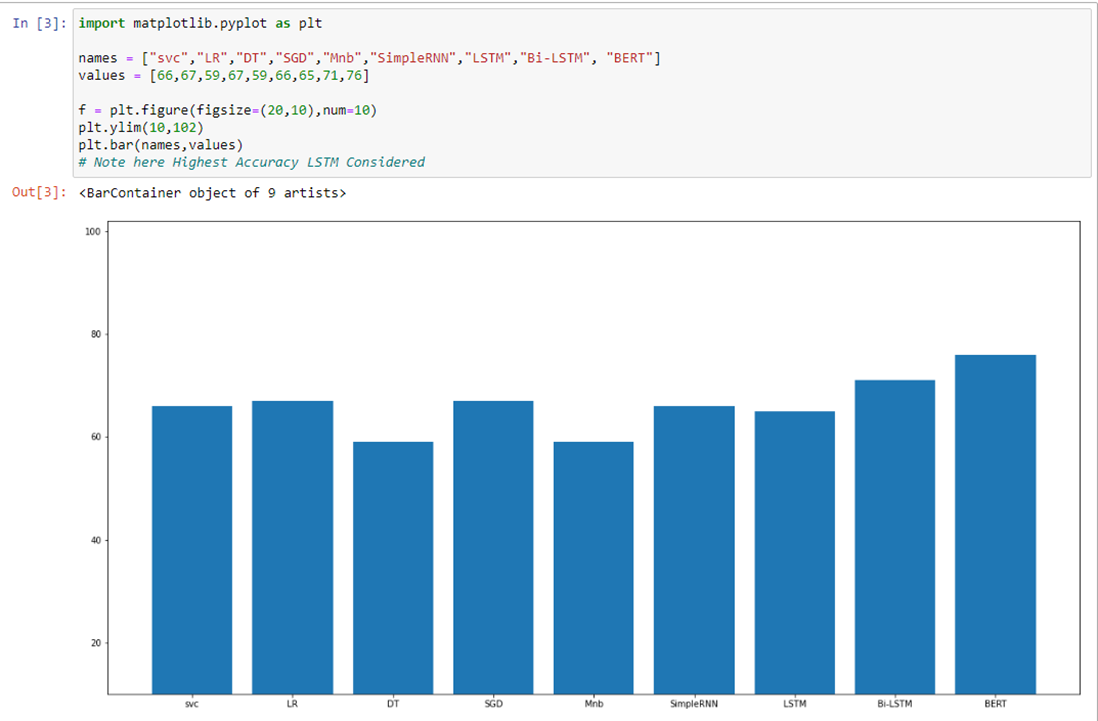